In [1]:
import pandas as pd
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from typing import Any
from funcoes import aplicar_imputacao_treino,plot_comparacao_roc \
                    ,plot_comparacao_prc,aplicar_imputacao_teste,escolher_estrategia_imputacao \
                    ,plot_comparacao_ks,plot_comparacao_decil,gerar_tabela_avaliacao,plotar_ks_safra \
                    ,calcular_ks_por_safra,monitorar_variaveis_continuas,obter_importancia_variaveis \
                    ,calcular_metricas_multiplas,escorar_modelo,treinar_e_tunar_modelo,plot_comparacao_lift \
                    ,plot_matriz_confusao,calcular_ks_para_multiplas_bases,plotar_ks_safra


(CVXPY) Feb 09 04:53:53 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 09 04:53:53 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [7]:
#Lendo a base de treino
train_selecionada = pd.read_csv("train_selecionada.csv")

In [8]:
# Por padrão o Pycaret não permite a imputação dinâmica de missings, então vamos tratar os missings com nossa função e depois aplicar no teste OOS do pycaret
# Assim o setup não vai precisar tratar os missings, pois o dataset não terá missings para tratar
# Vamos salvar esse pipeline e utilizar no código de escoragem

In [9]:
regra_imputacao = escolher_estrategia_imputacao(train_selecionada)
train_selecionada, regra_imputacao, dict_mediana, dict_media = aplicar_imputacao_treino(train_selecionada,regra_imputacao)


In [10]:
train_selecionada.shape

(7315, 43)

In [18]:
#Definindo parâmetros, bases e técnicas gerais
setup_params = {
    #'data': train_selecionada.drop(columns=['id', 'safra']),
    #'target': 'y',
    'fold_shuffle': True, #mesmo papel da seed

    # Balanceamento de classes (SMOTE pode ser testado mesmo com 30% de 1 e 70% de 0)
    # 'fix_imbalance': True,
    # 'fix_imbalance_method': 'SMOTE',

    # Tratamento de valores ausentes
    'numeric_imputation': 'median',
    'categorical_imputation': 'most_frequent',

    # Discretização (binning) de variáveis numéricas para reduzir oscilações extremas
    'bin_numeric_features': [],

    # Divisão dos dados
    'train_size': 0.9,
    'data_split_shuffle': True,  # Embaralhar antes de dividir
    'data_split_stratify': True,  # Estratificação para manter a proporção das classes

    # Configuração da validação cruzada
    'session_id': 42,
    'verbose': False,
    'fold_strategy': 'stratifiedkfold',
    'fold': 10,

    # Remoção de multicolinearidade
    'remove_multicollinearity': True,
    'multicollinearity_threshold': 0.9,  # Remove features com correlação acima de 90%

    # Engenharia de atributos
    # 'polynomial_features': True,
    # 'polynomial_degree': 2,

    # Normalização dos dados
    'normalize': True,
    'normalize_method': 'zscore',  # (valor - média) / desvio padrão

    # Seleção de características
    'feature_selection': False  # Já realizado anteriormente
}

In [13]:
#Por se tratar de um problema de classificação Binário temos algumas opções de modelos que pdoemos testar
modelos_classificacao = [
    "lr - Logistic Regression",
    "knn - K Neighbors Classifier",
    "nb - Naive Bayes",
    "dt - Decision Tree Classifier",
    "svm - SVM (Linear Kernel)",
    "rbfsvm - SVM (Radial Kernel)",
    "gpc - Gaussian Process Classifier",
    "mlp - Multi-Level Perceptron (Neural Network)",
    "ridge - Ridge Classifier",
    "rf - Random Forest",
    "qda - Quadratic Discriminant Analysis",
    "ada - AdaBoost Classifier",
    "gbc - Gradient Boosting Classifier",
    "lda - Linear Discriminant Analysis",
    "et - Extra Trees Classifier",
    "xgboost - Extreme Gradient Boosting",
    "lightgbm - Light Gradient Boosting Machine",
    "catboost - CatBoost Classifier"
]

In [15]:
custom_grid_lightgbm = {
# ajusta a influência das classes automaticamente. (testando)
            'class_weight': ['balanced'],# Número máximo de folhas em cada árvore (define a complexidade dos splits)
            # Valores maiores permitem capturar interações mais complexas, mas aumentam o risco de overfitting.
            'num_leaves': [3, 5, 10, 20],# Taxa de aprendizado (step size que controla o ajuste do modelo a cada iteração)
            # Valores menores tornam o treinamento mais estável, mas exigem mais iterações.
            'learning_rate': [0.005, 0.01, 0.03],# Número total de árvores no modelo
            # Um número maior pode melhorar a performance, mas pode levar a overfitting se for muito alto.
            'n_estimators': [50, 100, 200], # Profundidade máxima das árvores (limita a complexidade do modelo)
            # Evita que o modelo fique muito profundo e overfitado aos dados de treino.
            'max_depth': [3, 5],# Fracção aleatória das amostras usadas para construir cada árvore (controle de bagging)
            # Valores menores aumentam a diversidade das árvores e reduzem overfitting.
            'subsample': [0.6, 0.75, 0.9],# Fracção das features usadas para construir cada árvore (controle de feature bagging)
            # Reduz a dependência de features específicas, melhorando a generalização.
            'colsample_bytree': [0.6, 0.75, 0.9],# Regularização L1 (Lasso), penaliza coeficientes grandes e força alguns a zero
            # Ajuda a reduzir o overfitting tornando o modelo mais simples.
            'reg_alpha': [0.1, 0.5, 1, 2],# Regularização L2 (Ridge), penaliza coeficientes grandes, mas sem zerá-los# Suaviza os pesos do modelo e ajuda na generalização.
            'reg_lambda': [0.1, 0.5, 1, 2]
}


# Hiperparâmetros para Regressão Logística
custom_grid_logistic_regression = {
    'C': [0.01, 0.1, 1, 10, 100],  # Controle de regularização: valores menores impõem mais penalidade
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Algoritmos de otimização para encontrar os coeficientes
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Tipo de regularização aplicada
    'max_iter': [100, 200, 500]  # Número máximo de iterações do solver
}

# Hiperparâmetros para Random Forest
custom_grid_random_forest = {
    'class_weight': ['balanced'],
    'n_estimators': [50,100,200],  # Número de árvores na floresta
    'max_depth': [3, 5, 7],  # Profundidade máxima das árvores
    'min_samples_split': [2, 5, 10],  # Mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 5],  # Mínimo de amostras em cada folha, valores maiores evitam overfitting
    'bootstrap': [True, False],  # Se usa ou não amostragem com reposição
    'max_features': ['sqrt', 'log2', None]  # Número máximo de features usadas para cada árvore
}

# Hiperparâmetros para XGBoost
custom_grid_xgboost = {
    'class_weight': ['balanced'],
    'learning_rate': [0.01, 0.05, 0.1],  # Taxa de aprendizado, controla o impacto de cada árvore
    'n_estimators': [50, 100,200],  # Número de árvores no modelo
    'max_depth': [3, 5, 10],  # Profundidade máxima de cada árvore
    'subsample': [0.6, 0.8, 1.0],  # Proporção dos dados usada em cada árvore, ajuda a reduzir overfitting
    'colsample_bytree': [0.6, 0.8, 1.0],  # Porcentagem de features usadas por árvore
    'gamma': [0, 0.1, 0.2, 0.3],  # Reduz a divisão de nós pouco informativos, ajudando no controle de overfitting
    'reg_lambda': [0, 1, 10],  # Regularização L2 para evitar overfitting
    'reg_alpha': [0, 1, 10]  # Regularização L1 para tornar o modelo mais esparso
}

# Hiperparâmetros para LightGBM


In [ ]:

#custom_grid_lightgbm
#custom_grid_logistic_regression
#custom_grid_random_forest
#custom_grid_xgboost

In [50]:
##rf,lr,xgboost,lightgbm
nome_modelo = 'xgboost'

In [51]:
modelo = treinar_e_tunar_modelo(target='y',
                                data=train_selecionada.drop(columns=['id', 'safra']),
                                model_name=nome_modelo,
                                setup_params=setup_params,
                                tune_params=custom_grid_xgboost,
                                problem_type='classification')



,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7800,0.7716,0.4516,0.6614,0.5367,0.3991,0.4116
1,0.7496,0.7667,0.3925,0.5840,0.4695,0.3138,0.3244
2,0.7800,0.7947,0.4355,0.6694,0.5277,0.3925,0.4080
3,0.7644,0.7595,0.4108,0.6230,0.4951,0.3498,0.3627
4,0.7644,0.7870,0.3925,0.6348,0.4850,0.3432,0.3599
5,0.7720,0.7783,0.4624,0.6324,0.5342,0.3880,0.3964
6,0.7614,0.7741,0.3656,0.6355,0.4642,0.3248,0.3453
7,0.7629,0.7508,0.3978,0.6271,0.4868,0.3426,0.3576
8,0.7492,0.7330,0.4032,0.5814,0.4762,0.3184,0.3276


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7891,0.7985,0.3763,0.7527,0.5018,0.3863,0.4237
1,0.7724,0.7928,0.3656,0.6800,0.4755,0.3465,0.3738
2,0.7982,0.7981,0.4409,0.7387,0.5522,0.4325,0.4565
3,0.7705,0.7830,0.3622,0.6700,0.4702,0.3399,0.3662
4,0.7812,0.8002,0.3978,0.6981,0.5068,0.3795,0.4043
5,0.7933,0.8114,0.3978,0.7551,0.5211,0.4051,0.4389
6,0.7736,0.7973,0.3387,0.7079,0.4582,0.3368,0.3734
7,0.7766,0.7700,0.3548,0.7097,0.4731,0.3508,0.3847
8,0.7781,0.7678,0.4032,0.6818,0.5068,0.3756,0.3971


Fitting 10 folds for each of 10 candidates, totalling 100 fits


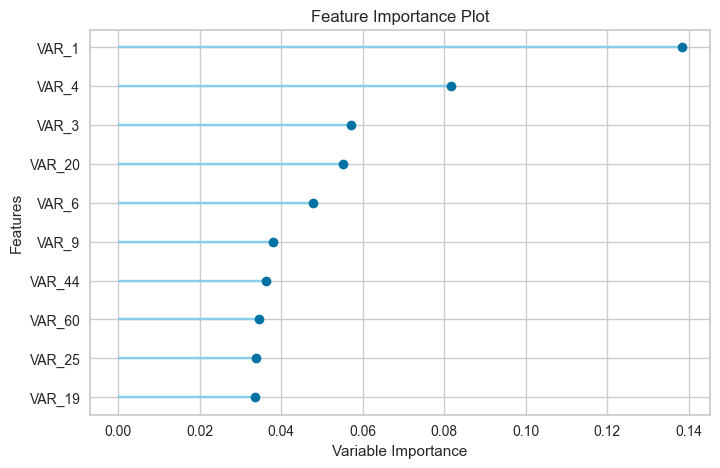

In [52]:
plot_model(modelo,'feature')

In [53]:
# Acessando a importância das variáveis diretamente
importances = modelo.feature_importances_
features = modelo.feature_names_in_

# Criando um DataFrame com os valores
import pandas as pd
df_importancia = pd.DataFrame({'Variavel': features, 'Importancia': importances})
df_importancia = df_importancia.sort_values(by='Importancia', ascending=False)
df_importancia.to_csv(f'{nome_modelo}_importancia_vars.csv',sep=",",index=False)


In [47]:
##se regressão logística
#import pandas as pd
#import numpy as np
#
## Acessar os coeficientes do modelo treinado
#coeficientes = modelo.coef_[0]  # O PyCaret retorna um array, pegamos a primeira linha
## Acessar os nomes das variáveis
#features = modelo.feature_names_in_
## Criar um DataFrame com os coeficientes
#df_importancia = pd.DataFrame({'Feature': features, 'Importance': coeficientes})
## Ordenar pela importância absoluta (valores mais altos têm mais influência)
#df_importancia['Abs_Importance'] = np.abs(df_importancia['Importance'])
#df_importancia = df_importancia.sort_values(by='Abs_Importance', ascending=False).drop(columns=['Abs_Importance'])
#df_importancia.to_csv(f'{nome_modelo}_importancia_vars.csv',sep=",",index=False)

In [54]:
df_importancia.head()

,Variavel,Importancia
5,VAR_1,0.138388
32,VAR_4,0.081567
3,VAR_3,0.057029
23,VAR_20,0.055248
8,VAR_6,0.047773


In [55]:
save_model(modelo,f'tuned_{nome_modelo}')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['VAR_15', 'VAR_9', 'VAR_54',
                                              'VAR_3', 'VAR_5', 'VAR_1',
                                              'VAR_28', 'VAR_60', 'VAR_45',
                                              'VAR_6', 'VAR_58', 'VAR_38',
                                              'VAR_32', 'VAR_19', 'VAR_8',
                                              'VAR_17', 'VAR_33', 'VAR_30',
                                              'VAR_2', 'VAR_11', 'VAR_24',
                                              'VAR_25', 'VAR_65', 'VAR_59',
                                              'VAR_53', 'VAR_20', 'VAR_57',
                                              'VAR_44...
                                feature_types=None, gamma=0.3, grow_policy=None,
                                importance_type=None,
 

In [56]:
#Escorar a base de treino
train_lightgbm = escorar_modelo(base_treino=train_selecionada, base_dados_escorar=train_selecionada, caminho_modelo='tuned_lightgbm')
train_lr = escorar_modelo(base_treino=train_selecionada, base_dados_escorar=train_selecionada, caminho_modelo='tuned_lr')
train_rf = escorar_modelo(base_treino=train_selecionada, base_dados_escorar=train_selecionada, caminho_modelo='tuned_rf')
train_xgboost = escorar_modelo(base_treino=train_selecionada, base_dados_escorar=train_selecionada, caminho_modelo='tuned_xgboost')

Transformation Pipeline and Model Successfully Loaded
Modelo 'tuned_lightgbm' carregado com sucesso!


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.5467,0.8228,0.9511,0.3793,0.5424,0.2324,0.3353


Transformation Pipeline and Model Successfully Loaded
Modelo 'tuned_lr' carregado com sucesso!


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7322,0.7840,0.6428,0.5210,0.5755,0.3830,0.3875


Transformation Pipeline and Model Successfully Loaded
Modelo 'tuned_rf' carregado com sucesso!


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.5340,0.8393,0.9681,0.3743,0.5399,0.2236,0.3360


Transformation Pipeline and Model Successfully Loaded
Modelo 'tuned_xgboost' carregado com sucesso!


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7643,0.8338,0.7144,0.5655,0.6313,0.4615,0.4683


In [57]:
#Ler a base OOT e OOS
test_oos = pd.read_csv('test_oos.csv')
test_oos = test_oos[train_selecionada.columns]
test_oos_lightgbm = escorar_modelo(base_treino=train_selecionada, base_dados_escorar=test_oos, caminho_modelo='tuned_lightgbm')
test_oos_lr = escorar_modelo(base_treino=train_selecionada, base_dados_escorar=test_oos, caminho_modelo='tuned_lr')
test_oos_rf = escorar_modelo(base_treino=train_selecionada, base_dados_escorar=test_oos, caminho_modelo='tuned_rf')
test_oos_xgboost = escorar_modelo(base_treino=train_selecionada, base_dados_escorar=test_oos, caminho_modelo='tuned_xgboost')

Transformation Pipeline and Model Successfully Loaded
Modelo 'tuned_lightgbm' carregado com sucesso!


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.5156,0.7917,0.9283,0.3607,0.5195,0.1906,0.2843


Transformation Pipeline and Model Successfully Loaded
Modelo 'tuned_lr' carregado com sucesso!


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7381,0.7857,0.6492,0.5292,0.5831,0.3951,0.3995


Transformation Pipeline and Model Successfully Loaded
Modelo 'tuned_rf' carregado com sucesso!


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.4822,0.7797,0.9264,0.3446,0.5024,0.1548,0.2460


Transformation Pipeline and Model Successfully Loaded
Modelo 'tuned_xgboost' carregado com sucesso!


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7387,0.7929,0.6628,0.5294,0.5886,0.4006,0.4061


In [58]:
#Ler a base OOT
test_oot = pd.read_csv('teste_oot.csv')
test_oot = test_oot[train_selecionada.columns]
#Escorar as bases 
test_oot_lightgbm = escorar_modelo(base_treino=train_selecionada, base_dados_escorar=test_oot, caminho_modelo='tuned_lightgbm')
test_oot_lr = escorar_modelo(base_treino=train_selecionada, base_dados_escorar=test_oot, caminho_modelo='tuned_lr')
test_oot_rf = escorar_modelo(base_treino=train_selecionada, base_dados_escorar=test_oot, caminho_modelo='tuned_rf')
test_oot_xgboost = escorar_modelo(base_treino=train_selecionada, base_dados_escorar=test_oot, caminho_modelo='tuned_xgboost')

Transformation Pipeline and Model Successfully Loaded
Modelo 'tuned_lightgbm' carregado com sucesso!


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.5621,0.7121,0.8626,0.4305,0.5744,0.2162,0.2743


Transformation Pipeline and Model Successfully Loaded
Modelo 'tuned_lr' carregado com sucesso!


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6920,0.7059,0.4341,0.5656,0.4912,0.2758,0.2807


Transformation Pipeline and Model Successfully Loaded
Modelo 'tuned_rf' carregado com sucesso!


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.5402,0.6977,0.8736,0.4181,0.5655,0.1904,0.2526


Transformation Pipeline and Model Successfully Loaded
Modelo 'tuned_xgboost' carregado com sucesso!


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.6901,0.7147,0.4817,0.5549,0.5157,0.2895,0.2911


In [59]:
#Todas as bases tem o mesmo schema ['id', 'safra', 'y', 'score_1', 'score_0']

In [60]:
#Verificando as volumetrias de Treino
train_lightgbm.shape,train_lr.shape,train_rf.shape,train_xgboost.shape

((7315, 5), (7315, 5), (7315, 5), (7315, 5))

In [61]:
#Verificando as volumetrias OOS
test_oos_lightgbm.shape,test_oos_lr.shape,test_oos_rf.shape,test_oos_xgboost.shape

((1829, 5), (1829, 5), (1829, 5), (1829, 5))

In [62]:
#Verificando as volumetrias OOT
test_oot_lightgbm.shape,test_oot_lr.shape,test_oot_rf.shape,test_oot_xgboost.shape

((1594, 5), (1594, 5), (1594, 5), (1594, 5))

In [63]:
#métricas que dependem do Limiar de corte
#Acurácia: Percentual de acertos (total correto / total de previsões).
#Precisão: Entre os positivos previstos, quantos realmente são positivos (TP / (TP + FP)).
#Recall: Entre os positivos reais, quantos foram identificados corretamente (TP / (TP + FN)).
#F1-score: Média harmônica entre precisão e recall (2 × (Precisão × Recall) / (Precisão + Recall)).
#AUC (Área sob a curva ROC): Mede a capacidade do modelo de separar classes, variando entre 0 e 1.
#KS MAX (Kolmogorov-Smirnov): Diferença máxima entre taxas cumulativas de verdadeiros positivos e falsos positivos.
#GINI: Mede a desigualdade na distribuição das previsões, baseado no AUC (GINI = 2 × AUC - 1).
#TP (True Positive): Positivos corretos (modelo previu positivo e era positivo).
#FP (False Positive): Falsos positivos (modelo previu positivo, mas era negativo).
#TN (True Negative): Negativos corretos (modelo previu negativo e era negativo).
#FN (False Negative): Falsos negativos (modelo previu negativo, mas era positivo).

bases_nomeadas = {
    "Train - LightGBM": train_lightgbm,
    "Test - LightGBM": test_oos_lightgbm,
    "OOT - LightGBM": test_oot_lightgbm,
    "Train - Regressão Logística": train_lr,
    "Test - Regressão Logística": test_oos_lr,
    "OOT - Regressão Logística": test_oot_lr,
    "Train - Random Forest": train_rf,
    "Test - Random Forest": test_oos_rf,
    "OOT - Random Forest": test_oot_rf,
    "Train - Xgboost": train_xgboost,
    "Test - Xgboost": test_oos_xgboost,
    "OOT - Xgboost": test_oot_xgboost

}
calcular_metricas_multiplas(bases_nomeadas, limiar = 0.3) #0.3 significa que acima de 30% de prob de mau consideramos mau.

,Nome da Base,Acurácia,Precisão,Recall,F1-score,AUC,KS MAX,GINI,TP,FP,TN,FN
0,Train - LightGBM,0.5465,0.3793,0.9511,0.5423,0.8228,0.4753,0.6456,1965,3216,2033,101
1,Test - LightGBM,0.5156,0.3607,0.9283,0.5195,0.7917,0.4569,0.5834,479,849,464,37
2,OOT - LightGBM,0.5621,0.4305,0.8626,0.5744,0.7121,0.3082,0.4242,471,623,425,75
3,Train - Regressão Logística,0.7322,0.5210,0.6428,0.5755,0.7840,0.4142,0.5680,1328,1221,4028,738
4,Test - Regressão Logística,0.7381,0.5292,0.6492,0.5831,0.7857,0.4283,0.5713,335,298,1015,181
5,OOT - Regressão Logística,0.6913,0.5643,0.4341,0.4907,0.7059,0.3149,0.4118,237,183,865,309
6,Train - Random Forest,0.5340,0.3743,0.9681,0.5399,0.8393,0.4993,0.6785,2000,3343,1906,66
7,Test - Random Forest,0.4817,0.3444,0.9264,0.5021,0.7797,0.4277,0.5593,478,910,403,38
8,OOT - Random Forest,0.5402,0.4181,0.8736,0.5655,0.6977,0.3024,0.3954,477,664,384,69
9,Train - Xgboost,0.7643,0.5655,0.7144,0.6313,0.8338,0.5045,0.6675,1476,1134,4115,590


In [64]:
bases_nomeadas = {
    "Train - LightGBM": [train_lightgbm,1],
    "Test - LightGBM": [test_oos_lightgbm,1],
    "OOT - LightGBM": [test_oot_lightgbm,1],
    "Train - Regressão Logística": [train_lr,2],
    "Test - Regressão Logística": [test_oos_lr,2],
    "OOT - Regressão Logística": [test_oot_lr,2],
    "Train - Random Forest": [train_rf,3], 
    "Test - Random Forest": [test_oos_rf,3],
    "OOT - Random Forest": [test_oot_rf,3], 
    "Train - Xgboost": [train_xgboost,4],
    "Test - Xgboost": [test_oos_xgboost,4],
    "OOT - Xgboost": [test_oot_xgboost,4],
}
nome_graficos = {1 : 'LightGBM',
                 2 : 'Regressão Logística',
                 3 : 'Random Forest',
                 4 : 'XgBoost'
                 }

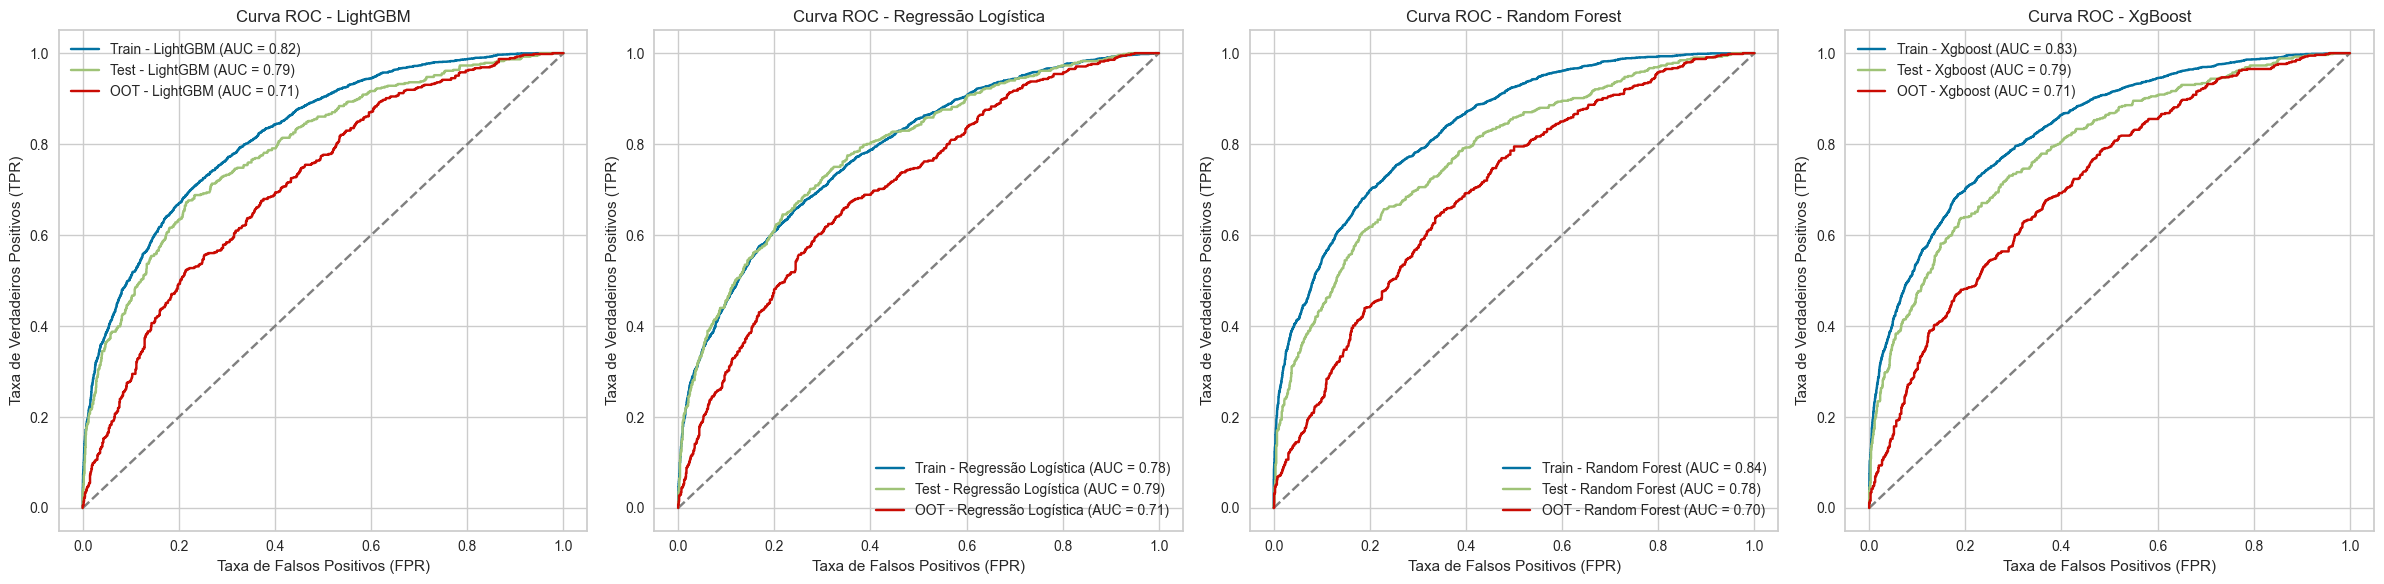

In [65]:
plot_comparacao_roc(bases_nomeadas,nome_graficos)

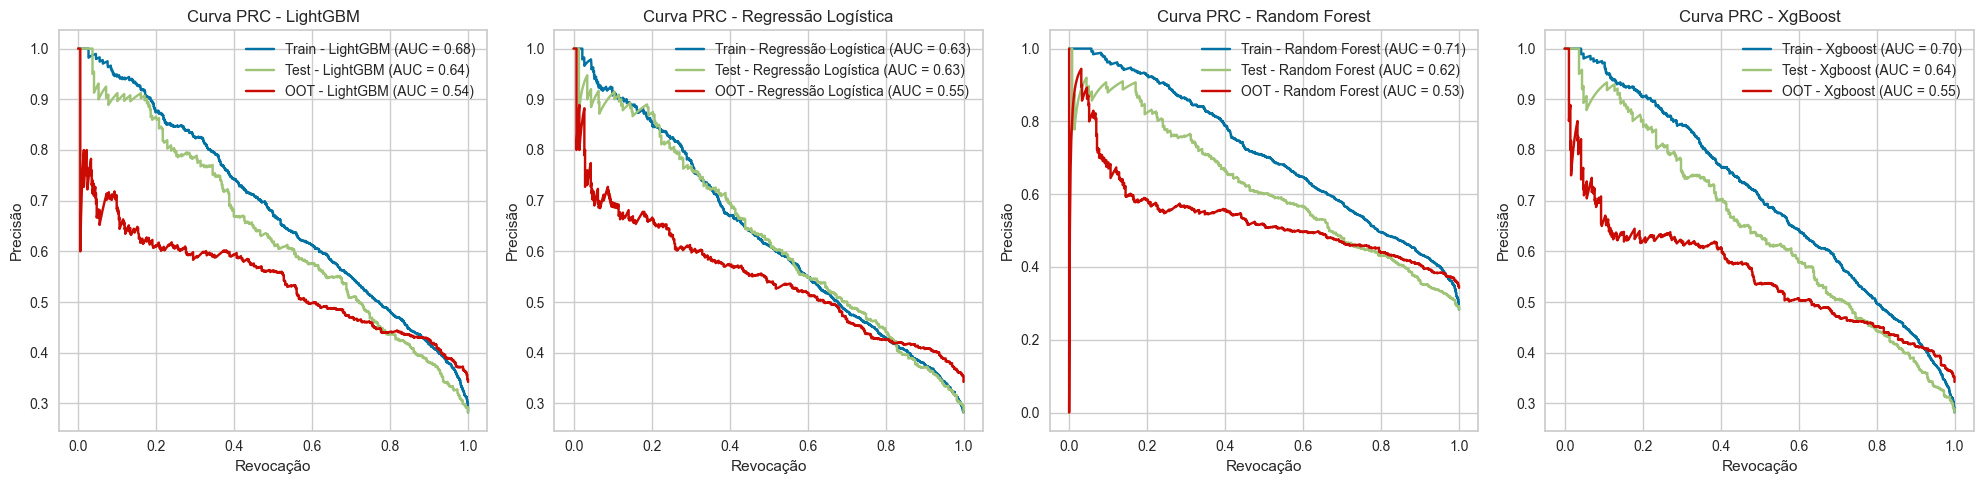

In [66]:
#2. Curva PRC (Precision-Recall Curve)
#Mostra a relação entre Precisão (Precision) e Revocação (Recall - Sensibilidade).
#Útil quando a classe positiva é rara (dados desbalanceados).
#A métrica associada é a AUC-PR, que mede a área sob essa curva.
#Se houver um grande desbalanceamento entre as classes (por exemplo, detecção de fraudes, doenças raras).

plot_comparacao_prc(bases_nomeadas,nome_graficos)

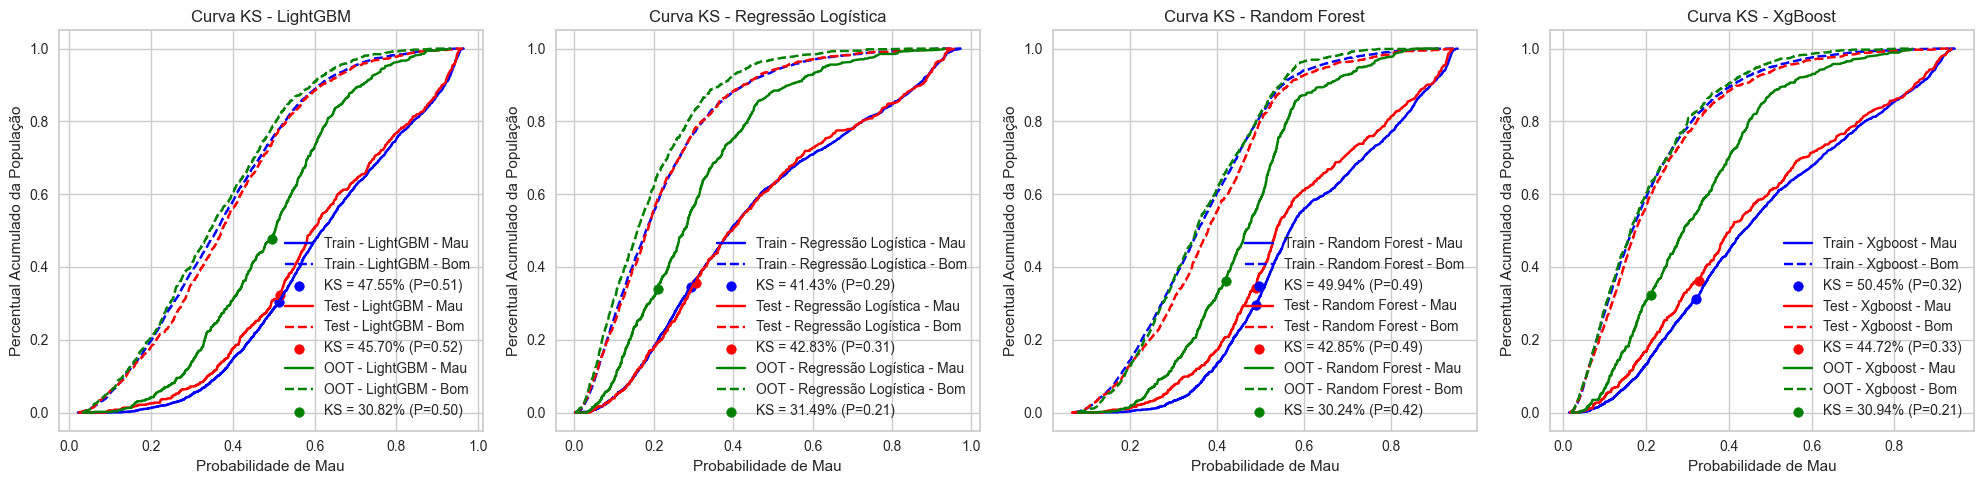

In [67]:
#3. Curva KS (Kolmogorov-Smirnov Curve)
#Mede a diferença máxima entre as distribuições cumulativas de positivos e negativos.
#Quanto maior o valor de KS, melhor a separação do modelo.
#Muito utilizada em modelos de risco de crédito e em cenários onde se quer saber o ponto de máxima separação entre as classes.

plot_comparacao_ks(bases_nomeadas,nome_graficos)

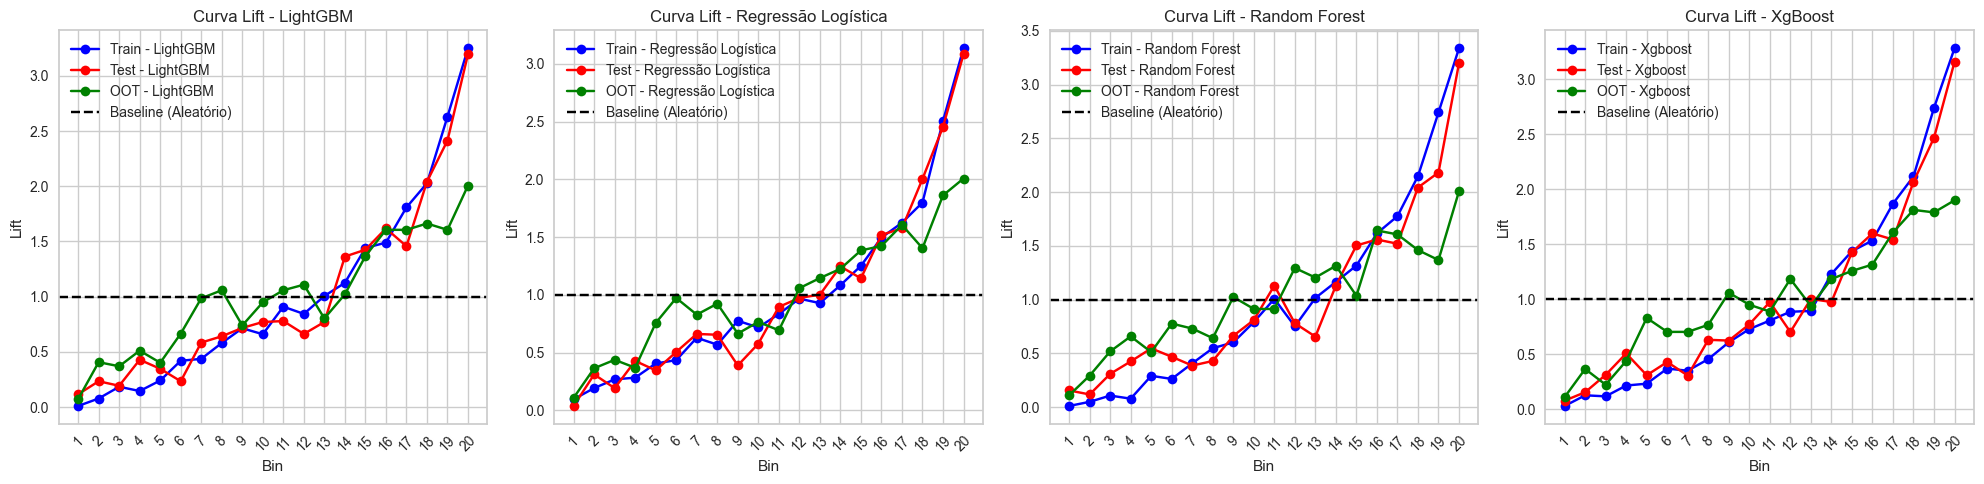

In [68]:
#4. Curva Lift
#mede o ganho que o modelo proporciona na identificação da classe positiva em comparação com uma escolha aleatória.
#
#Se o modelo for bom, ele identificará corretamente a classe positiva nos primeiros percentis do score.
#Se o modelo for ruim, a curva será próxima da linha base (Lift = 1), indicando que ele não melhora a seleção da classe positiva.
#Melhor modelo → Curva Lift começa alta e cai suavemente.
#Modelo ruim → Curva Lift próxima de 1 (modelo não faz diferença).


plot_comparacao_lift(bases_nomeadas, nome_graficos,n_bins=20)

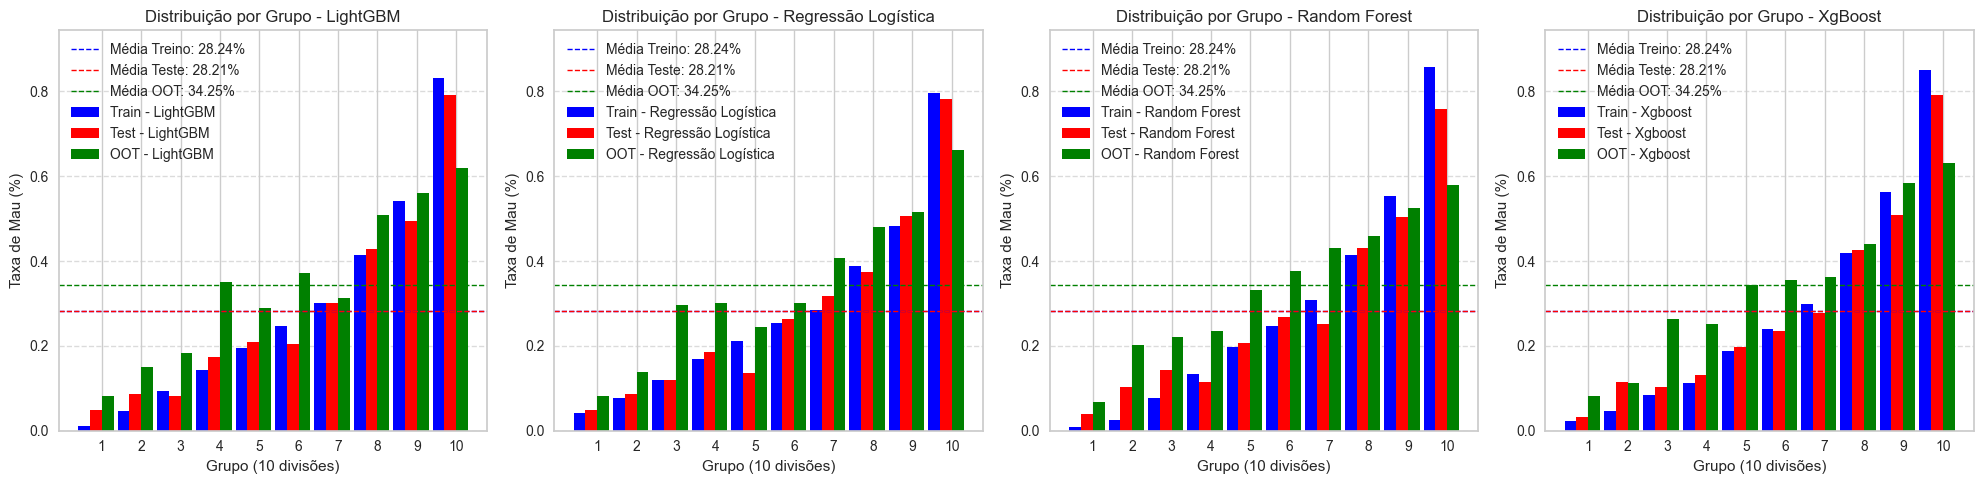

In [69]:
#Verificar se o score está ordenando bem e seguindo uma lógica onde quanto maior a probabilidade de mau, maior o % de maus acumulados
#Ordenamos o score do menor para o maior 
#Criamos faixas discretas e verificamos a quantidade de maus em cada faixa
#Quanto mais ordenadas forem as faixas melhor
plot_comparacao_decil(bases_nomeadas, nome_graficos,num_divisoes= 10)

In [70]:
bases_nomeadas = {
    "Train - LightGBM": [train_lightgbm,1],
    "Test - LightGBM": [test_oos_lightgbm,1],
    "OOT - LightGBM": [test_oot_lightgbm,1],
    "Train - Regressão Logística": [train_lr,2],
    "Test - Regressão Logística": [test_oos_lr,2],
    "OOT - Regressão Logística": [test_oot_lr,2],
    "Train - Random Forest": [train_rf,3], 
    "Test - Random Forest": [test_oos_rf,3],
    "OOT - Random Forest": [test_oot_rf,3], 
    "Train - Xgboost": [train_xgboost,4],
    "Test - Xgboost": [test_oos_xgboost,4],
    "OOT - Xgboost": [test_oot_xgboost,4],

} 

In [71]:
avaliar_modelos_mc = {"OOT - LightGBM": test_oot_lightgbm,
                  "OOT - Regressão Logística": test_oot_lr,
                  "OOT - Random Forest": test_oot_rf,
                  "OOT - Xgboost": test_oot_xgboost}

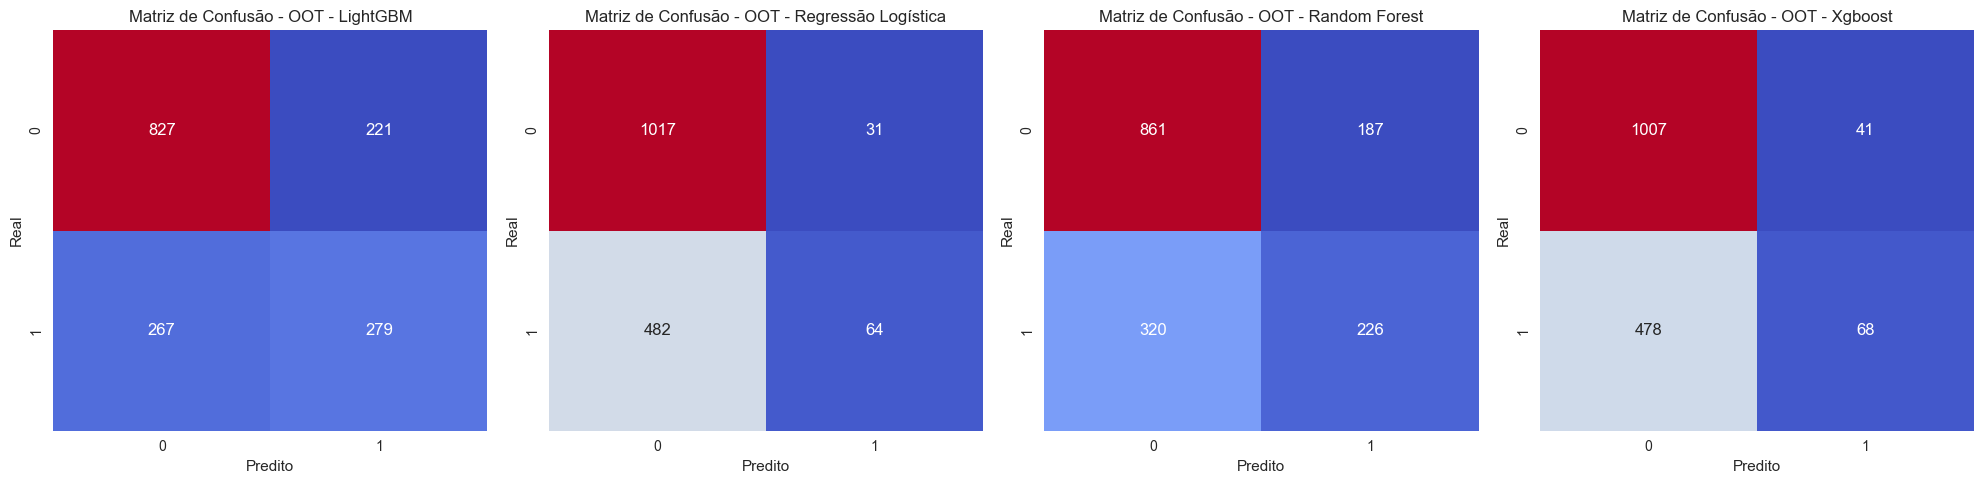

In [72]:
plot_matriz_confusao(avaliar_modelos_mc, limiar=0.5, perc=False)


In [73]:
#Somente OOT
bases_nomeadas_simples = {
    "OOT - LightGBM": test_oot_lightgbm,
    "OOT - Regressão Logística": test_oot_lr,
    "OOT - Random Forest": test_oot_rf,
    "OOT - Xgboost": test_oot_xgboost
}
calcular_metricas_multiplas(bases_nomeadas_simples, limiar = 0.5) #0.3 significa que acima de 30% de prob de mau consideramos mau.

,Nome da Base,Acurácia,Precisão,Recall,F1-score,AUC,KS MAX,GINI,TP,FP,TN,FN
0,OOT - LightGBM,0.6939,0.5580,0.5110,0.5335,0.7121,0.3082,0.4242,279,221,827,267
1,OOT - Regressão Logística,0.6782,0.6737,0.1172,0.1997,0.7059,0.3149,0.4118,64,31,1017,482
2,OOT - Random Forest,0.6819,0.5472,0.4139,0.4713,0.6977,0.3024,0.3954,226,187,861,320
3,OOT - Xgboost,0.6744,0.6239,0.1245,0.2076,0.7147,0.3094,0.4294,68,41,1007,478


In [74]:
ks_por_safra_dict = {
    "LightGBM": pd.concat([test_oos_lightgbm,test_oot_lightgbm]),
    "Regressão Logística": pd.concat([test_oos_lr,test_oot_lr]),
    "Random Forest": pd.concat([test_oos_rf,test_oot_rf]),
    "Xgboost": pd.concat([test_oos_xgboost,test_oot_xgboost])
}

In [75]:
tabela_ks = calcular_ks_para_multiplas_bases(ks_por_safra_dict)

In [76]:
tabela_ks.head()

,safra,contagem_de_linhas,ks_max,ponto_ks,Base
0,201401,199,41.362162,0.5218,LightGBM
1,201402,184,46.467236,0.7817,LightGBM
2,201403,180,59.820065,0.6066,LightGBM
3,201404,187,44.887218,0.5304,LightGBM
4,201405,178,63.293812,0.5161,LightGBM


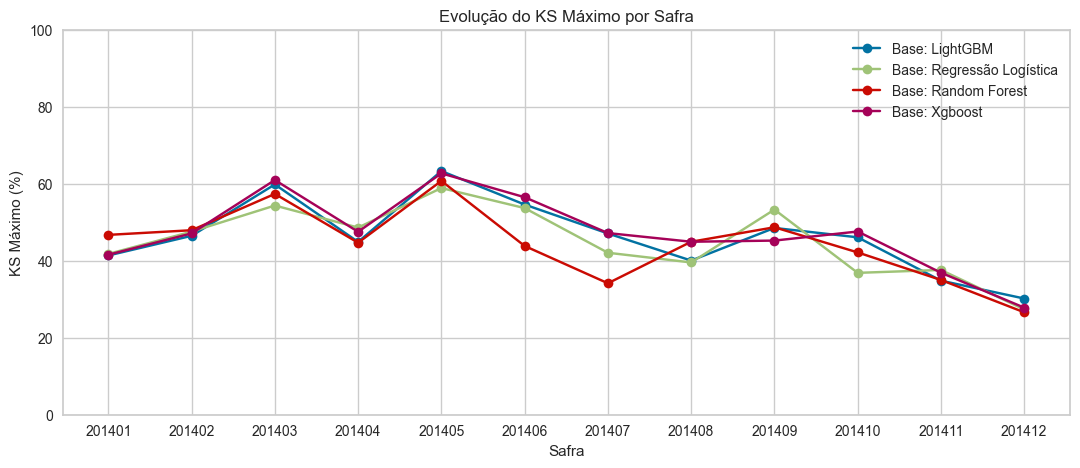

In [77]:
plotar_ks_safra(tabela_ks)

In [78]:
# O que leva nosso modelo a perder performance no OOT?
#Se o modelo perdeu performance no OOT, algumas causas podem ser:
#
#Mudança nos dados – Os padrões dos dados mudaram com o tempo.
#Mudança na relação com a target – As variáveis deixaram de influenciar o resultado da mesma forma.
#Overfitting – O modelo aprendeu muito bem o treino, mas não generaliza para novos períodos.
#Dados desatualizados – O treino foi feito com dados antigos e não reflete a realidade atual.
#Erros no processamento – Alguma transformação nos dados do OOT pode estar errada.
#Fatores externos – Eventos novos afetaram o comportamento dos dados (ex: crise, novas regras).

In [79]:
#Se uma variável que é importante para o modelo muda de distribuição, isso pode causar problemas na previsão.

#O p-valor mede a probabilidade de observarmos uma diferença tão grande entre duas amostras apenas por acaso, assumindo que elas vêm da mesma distribuição.
#Se p-valor < 0.05 → Existe menos de 5% de chance de que a diferença seja mero acaso. Ou seja, há evidências estatísticas de que as distribuições são diferentes!
#Se p-valor >= 0.05 → Não há evidências suficientes para afirmar que as distribuições mudaram.
#No caso do KS Test (Kolmogorov-Smirnov), um p-valor < 0.05 indica que a distribuição da variável mudou significativamente entre a safra de referência e a safra atual.

#O PSI (Índice de Estabilidade Populacional) mede a diferença entre duas distribuições.
#Dividimos os dados em faixas de valores, Calculamos as frequências relativas em cada bin para ambas as populações (referência e atual).
#PSI < 0.1 → Pequena diferença (distribuição estável)
#0.1 ≤ PSI < 0.25 → Diferença moderada (monitorar)
#PSI ≥ 0.25 → Diferença significativa (possível problema )


psi,ks = monitorar_variaveis_continuas(pd.concat([train_selecionada,test_oos]), test_oot, [x for x in train_selecionada.columns if x not in ['id','safra','y']])

In [80]:
reprovadas_ks = ks.index.tolist()
reprovadas_psi = psi.index.tolist()

In [81]:
reprovadas = reprovadas_ks + reprovadas_psi

In [82]:
reprovadas

['VAR_15',
 'VAR_9',
 'VAR_54',
 'VAR_3',
 'VAR_5',
 'VAR_1',
 'VAR_28',
 'VAR_60',
 'VAR_58',
 'VAR_17',
 'VAR_30',
 'VAR_2',
 'VAR_59',
 'VAR_53',
 'VAR_20',
 'VAR_57',
 'VAR_44',
 'VAR_52',
 'VAR_76',
 'VAR_4']

In [83]:
#verificando facilmente como a média da variável VAR_1 mudou nos meses mais recentes do OOT
train_selecionada['VAR_15'].mean(),test_oos['VAR_15'].mean(),test_oot['VAR_15'].mean()

(57.76628298017773, 57.75145981410608, 63.24588456712673)

In [84]:
#verificando facilmente como a média da variável VAR_1 mudou nos meses mais recentes do OOT
train_selecionada['VAR_1'].mean(),test_oos['VAR_1'].mean(),test_oot['VAR_1'].mean()

(34.32781954887218, 33.11591033351558, 22.331869510664994)

In [44]:
# Vamos salvar as bases escoradas para podermos avaliar melhor o modelo com métricas que dependem do Limiar de corte

#train_lightgbm_escorado.to_csv("train_lightgbm_escorado.csv",sep=",",index=False,header=True)
#test_lightgbm_escorado.to_csv("test_lightgbm_escorado.csv",sep=",",index=False,header=True)
#train_regressao_escorado.to_csv("train_regressao_escorado.csv",sep=",",index=False,header=True)
#test_regressao_escorado.to_csv("test_regressao_escorado.csv",sep=",",index=False,header=True)
#test_oot_lightgbm.to_csv("test_oot_lightgbm_escorado.csv",sep=",",index=False,header=True)
#test_oot_regressao.to_csv("test_oot_regressao_escorado.csv",sep=",",index=False,header=True)